In [1]:
import scipy.io as sio
import io 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def visualize_dataset(X):
    plt.scatter(X[..., 0], X[..., 1], marker='x', label='point')

In [3]:
def gaussian_distribution(X, mu, sigma2):
    p = (1 / np.sqrt(2 * np.pi * sigma2)) * np.exp(-(X - mu) ** 2 / (2 * sigma2))
    return np.prod(p, axis=1)  # in a row manner

In [4]:
def estimate_parameters_for_gaussian_distribution(X):
    mu = np.mean(X, axis=0)  # calculate according to column manner
    sigma2 = np.var(X, axis=0) 
    return mu, sigma2

In [5]:
def visualize_contours(mu, sigma2):
    x = np.linspace(5, 25, 100)
    y = np.linspace(5, 25, 100)
    xx, yy = np.meshgrid(x, y)
    X = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
    z = gaussian_distribution(X, mu, sigma2).reshape(xx.shape)
    cont_levels = [10 ** h for h in range(-20, 0, 3)]  # when z is in the current list, draw
    plt.contour(xx, yy, z, cont_levels)

In [6]:
def error_analysis(yp, yt):
    tp, fp, fn, tn = 0, 0, 0, 0
    for i in range(len(yp)):
        if yp[i] == yt[i]:
            if yp[i] == 1:
                tp += 1
            else:
                tn += 1
        else:
            if yp[i] == 1:
                fp += 1
            else:
                fn += 1
    precision = tp / (tp + fp) if tp + fp else 0  # just in case shouldn't be over 0
    recall = tp / (tp + fn) if tp + fn else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall else 0
    return f1

In [7]:
def select_threshold(yval, pval):
    epsilons = np.linspace(min(pval), max(pval), 1000)
    l = np.zeros((1, 2))
    for e in epsilons:
        ypre = (pval < e).astype(float)
        f1 = error_analysis(ypre, yval)
        l = np.concatenate((l, np.array([[e, f1]])), axis=0)
    index = np.argmax(l[..., 1])
    return l[index, 0], l[index, 1]

In [8]:
def detection(X, e, mu, sigma2):
    p = gaussian_distribution(X, mu, sigma2)
    anomaly_points = np.array([X[i] for i in range(len(p)) if p[i] < e])
    return anomaly_points

In [9]:
def circle_anomaly_points(X):
    plt.scatter(X[..., 0], X[..., 1], s=80, facecolors='none', edgecolors='r', label='anomaly point')

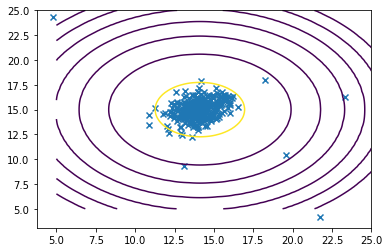

In [10]:
if __name__ == "__main__":
    data = sio.loadmat("ex8/ex8data1.mat")
    X = data['X']  # (307,2)
    visualize_dataset(X)
    mu, sigma2 = estimate_parameters_for_gaussian_distribution(X)
    p = gaussian_distribution(X, mu, sigma2)
    visualize_contours(mu, sigma2)

best choice of epsilon is  8.999852631901393e-05 ,the F1 score is  0.8750000000000001


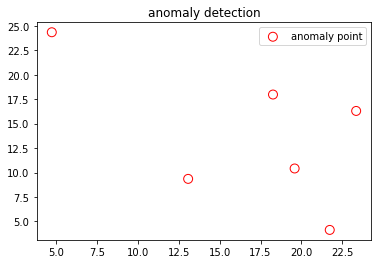

In [11]:
Xval = data['Xval']  # (307,2)
yval = data['yval']  # (307,1)
e, f1 = select_threshold(yval.ravel(), gaussian_distribution(Xval, mu, sigma2))
print('best choice of epsilon is ', e, ',the F1 score is ', f1)
anomaly_points = detection(X, e, mu, sigma2)
circle_anomaly_points(anomaly_points)
plt.title('anomaly detection')
plt.legend()
plt.show()

In [12]:
# High dimensional dataset
data2 = sio.loadmat("ex8/ex8data2.mat")
X = data2['X']
Xval = data2['Xval']
yval = data2['yval']
mu, sigma2 = estimate_parameters_for_gaussian_distribution(X)
e, f1 = select_threshold(yval.ravel(), gaussian_distribution(Xval, mu, sigma2))
anomaly_points = detection(X, e, mu, sigma2)
print('for this high dimensional dataset, the best choice of epsilon is ', e, ',the F1 score is ', f1)
print('the number of anomaly points is', anomaly_points.shape[0])

for this high dimensional dataset, the best choice of epsilon is  1.3786074982000235e-18 ,the F1 score is  0.6153846153846154
the number of anomaly points is 117


In [13]:
import scipy.io as sio
import numpy as np
import scipy.optimize as opt
from sklearn.metrics import mean_squared_error

In [14]:
def serialize(X, theta):
    return np.concatenate((X.flatten(), theta.flatten()), axis=0)

In [15]:
def deserialize(params, nm, nu, nf):
    X = params[:nm * nf].reshape(nm, nf)
    theta = params[nm * nf:].reshape(nu, nf)
    return X, theta

In [16]:
def collaborative_filtering_cost(params, Y, R, nm, nu, nf, l=0.0):
    X, theta = deserialize(params, nm, nu, nf)
    part1 = np.sum(((X.dot(theta.T) - Y) ** 2) * R) / 2
    part2 = l * np.sum(theta ** 2) / 2
    part3 = l * np.sum(X ** 2) / 2
    return part1 + part2 + part3

In [17]:
def collaborative_filtering_gradient(params, Y, R, nm, nu, nf, l=0.0):
    X, theta = deserialize(params, nm, nu, nf)
    g_X = ((X.dot(theta.T) - Y) * R).dot(theta) + l * X
    g_theta = ((X.dot(theta.T) - Y) * R).T.dot(X) + l * theta
    return serialize(g_X, g_theta)

In [18]:
def check_gradient(params, Y, R, nm, nu, nf):
    # X, theta = deserialize(params, nm, nu, nf)
    e = 0.0001
    m = len(params)
    g_params = np.zeros((m,))
    for i in range(m):
        temp = np.zeros((m,))
        temp[i] = e
        g_params[i] = (collaborative_filtering_cost(params + temp, Y, R, nm, nu, nf) -
                       collaborative_filtering_cost(params - temp, Y, R, nm, nu, nf)) / (2 * e)
    return g_params

In [19]:
def normalizeRatings(Y, R):
    Ymean = (Y.sum(axis=1) / R.sum(axis=1)).reshape(-1, 1)
    #     Ynorm = (Y - Ymean)*R 
    Ynorm = (Y - Ymean) * R
    return Ynorm, Ymean

In [20]:
data1 = sio.loadmat("ex8/ex8_movies.mat")
Y = data1["Y"]  # (1682,943)
R = data1["R"]  # (1682,943)
data2 = sio.loadmat("ex8/ex8_movieParams.mat")
X = data2["X"]  # (1682,10)
theta = data2["Theta"]  # (943,10)
nu = data2["num_users"][0][0]  # (1,1) 943
nm = data2["num_movies"][0][0]  # (1,1) 1682
nf = data2["num_features"][0][0]  # (1,1) 10

# let nm=5,nu=4,nf=3, the value is 22.224603725685675
# nu = 4
# nm = 5
# nf = 3
# X = X[:nm, :nf]
# theta = theta[:nu, :nf]
# Y = Y[:nm, :nu]
# R = R[:nm, :nu]
print(collaborative_filtering_cost(serialize(X, theta), Y, R, nm, nu, nf))
# lambda = 1.5
print(collaborative_filtering_cost(serialize(X, theta), Y, R, nm, nu, nf, 1.5))

# Gradient is too slow. so no running result yet
# print(collaborative_filtering_gradient(serialize(X, theta), Y, R, nm, nu, nf)[10],
#       check_gradient(serialize(X, theta), Y, R, nm, nu, nf)[10])

# read the lables for the movies
f = io.open("ex8/ex8_movies.mat", encoding="ISO-8859-1")
movies = []
for line in f.readlines():
    movies.append(line.split(' ', 1)[-1][:-1])

# train the model
# add some customerised data
my_ratings = np.zeros((1682, 1))
my_ratings[0] = 4
my_ratings[97] = 2
my_ratings[6] = 3
my_ratings[11] = 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

Y = np.concatenate((Y, my_ratings), axis=1)
R = np.concatenate((R, my_ratings > 0), axis=1)
nu += 1

params = serialize(np.random.random((nm, nf)), np.random.random((nu, nf)))
res = opt.minimize(fun=collaborative_filtering_cost, x0=params, args=(Y, R, nm, nu, nf, 10),
                        method='TNC',
                        jac=collaborative_filtering_gradient)
print(res)
sio.savemat("ex8/parameters.mat", {"params": res.x})
trained_X, trained_theta = deserialize(res.x, nm, nu, nf)
trained_X, trained_theta = deserialize(sio.loadmat("ex8/parameters.mat")["params"].ravel(), nm, nu, nf)
predict = trained_X.dot(trained_theta.T)
my_predict = predict[..., -1]

for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print(my_ratings[i], movies[i])
# select top 10 for recommendations
# results can vary because of different initialisation
print("Top recommendations for you:")
for i in range(10):
    index = int(np.argmax(my_predict))
    print("Predicting rating ", my_predict[index], " for movie ", movies[index])
    my_predict[index] = -1

Y = Y.flatten()
R = R.flatten()
predict = predict.flatten()
true_y = []
pre_y = []
for i in range(len(Y)):
    if R[i] == 1:
        true_y.append(Y[i])
        pre_y.append(predict[i])
print(mean_squared_error(true_y, pre_y))

27918.64012454421
34821.703613072226
     fun: 71900.76621802355
     jac: array([-2.09554525e-08,  4.20499530e-06,  3.10529650e-05, ...,
        1.79092408e-08, -4.07259797e-07,  1.16719796e-07])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 1345
     nit: 49
  status: 1
 success: True
       x: array([0.52273399, 0.32458126, 0.65905389, ..., 0.36943055, 0.8113261 ,
       0.44628814])
[4.] 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011                                                 IM   Ö÷ xìQN1D×ñÅwïáZ\p&f´ÝP»ªð«¶»ql¯ÓXÓ<-äe·<ðöÈKwsüFÃ;ÅøyåØy}<ïD ð"hõ0Í¸¹k´T@
[3.] Idê¬j=p+%·,öp	7Ì{ÇÔ8þÜÓ¦Íø³©ÅE+¢ßø-6AÃ©J%$òÏÛªÖ·dÁ¶¬q¹Ígñ½¦Påþ´ìò¨Ý
[5.] F2Îþ§¹zcÉD©*ëöðB
[4.]UÁÿÿåMP²ÆÙv»çL%#/sË-¦;¸~Ô\m¬@ñàÞ³Êùñá<æøÒ*]f¡Ð#~ooXùøQË ¿2ü; Õ
[5.] Ï/Ê»WüZhqh´sÊÉVo ÛÞè¿°m6á ^AÚ·èçQaàë²¬cf~ëáy!#êEµ¦$'Z¦BK,URVâMº¯:¨NÝäÑØ/y`Ì×è¿Âd ¬¸¶ü7¤|*$ý  ÿÿìY
[3.] hMº